In [1]:
import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import matplotlib.pylab as plt
import numpy as np
import torch.utils.data as data
import pandas as pd
from hyperopt import hp
from hyperopt.pyll.stochastic import sample
from hyperopt import rand, tpe, fmin
from hyperopt import Trials
import random
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from collections import OrderedDict
from torchsummary import summary

IMAGE_SIZE = 16

def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
    plt.title('y = '+ str(data_sample[1]))

c:\Users\mgiordano\Anaconda3\envs\Torch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<h2 id="Makeup_Data">This is a Notebook to test the hyperopt library as a tool for optimizing hyperparameters and gain more intuition for CNNs</h2>

Note: Some of the first cells here are based on code from IBMs PyTorch Coursera Course 

<h2 id="Makeup_Data">Get the Data</h2> 


In [2]:
composed = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor()])

train_dataset = dsets.MNIST(root='./data', train=True, download=True, transform=composed)
validation_dataset = dsets.MNIST(root='./data', train=False, download=True, transform=composed)

# train_dataset[number example][0=data, 1=label]

<h2 id="CNN">Build a CNN</h2>


In [3]:
class CNN_batch(nn.Module):
    
    # Contructor
    def __init__(self, out_1=8, out_2=16,number_of_classes=10):
        super(CNN_batch, self).__init__()
        out_1 = int(out_1)
        out_2 = int(out_2)
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, padding=2)
        self.conv1_bn = nn.BatchNorm2d(out_1)

        self.maxpool1=nn.MaxPool2d(kernel_size=2)
        
        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, stride=1, padding=2)
        self.conv2_bn = nn.BatchNorm2d(out_2)

        self.maxpool2=nn.MaxPool2d(kernel_size=2)
        
        self.fc1 = nn.Linear(out_2 * 4 * 4, number_of_classes)
        self.bn_fc1 = nn.BatchNorm1d(10)
    
    # Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x = self.conv1_bn(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = self.conv2_bn(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.bn_fc1(x)
        return x

<h2 id="Makeup_Data">Build Training Function</h2> 


In [4]:
def train_model(model,train_loader,validation_loader,optimizer,n_epochs=4):
    
    #global variable 
    N_test=len(validation_dataset)
    accuracy_list=[]
    loss_list=[]
    false_exs = []
    y_hats = []
    for epoch in range(n_epochs):
        # print('Epoch: ' + str(epoch))
        false_exs_tmp = []
        y_hats_tmp = []
        for x, y in train_loader:
            model.train()
            optimizer.zero_grad()
            z = model(x)
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            loss_list.append(loss.data)

        correct=0
        #perform a prediction on the validation  data  
        for (i,(x_test, y_test)) in enumerate(validation_loader):
            print(i)
            model.eval()
            z = model(x_test)
            _, yhat = torch.max(z.data, 1)
            iscorrect = (yhat == y_test).sum().item()
            correct += iscorrect
            tmp = yhat != y_test
            false_exs_tmp.append(tmp.numpy())
            y_hats_tmp.append(yhat.numpy())
        
        y_hats.append(y_hats_tmp)
        false_exs.append(false_exs_tmp)
        accuracy = correct / N_test
        accuracy_list.append(accuracy)
     
    return accuracy_list, loss_list, np.array(false_exs), np.array(y_hats)

<h2 id="Makeup_Data">Old code for random grid search.  Random Grid Search does not perform nearly as well</h2> 


In [5]:
# # Random grid search

# n_epochs = 10
# batch_size = 10000
# learning_rate = 0.1
# criterion = nn.CrossEntropyLoss()
# num_hypers = 10

# accuracy_lists = []
# loss_lists = []
# false_exs_lists = []
# y_hats_lists = []
# layer_size_1 = [random.randint(3,30) for q in range(num_hypers)]
# layer_size_2 = [random.randint(3,30) for q in range(num_hypers)]

# for i in range(num_hypers):
#     print('Hyperparameter Space ' + str(i))
#     model_batch=CNN_batch(out_1=layer_size_1[i], out_2=layer_size_2[i])
#     optimizer = torch.optim.SGD(model_batch.parameters(), lr = learning_rate)
#     train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100)
#     validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=batch_size)
#     accuracy_list_batch, loss_list_batch, false_exs, y_hats=train_model(model=model_batch,n_epochs=n_epochs,train_loader=train_loader,validation_loader=validation_loader,optimizer=optimizer)
#     accuracy_lists.append(accuracy_list_batch)
#     loss_lists.append(loss_list_batch)
#     false_exs_lists.append(false_exs)
#     y_hats_lists.append(y_hats)

# g1ds = data.Subset(validation_dataset,range(10000))
# g1labs = np.array([g1ds[q][1] for q in range(len(g1ds))])

# # plt.plot(loss_list_batch,'r',label='loss batch cnn')
# # plt.xlabel('iteration')
# # plt.title("loss")
# # plt.legend()

# for lab in range(10):
#     # iteration
#     tmp_acc = []
#     for it in range(n_epochs):
#         num_t = len(g1labs[(g1labs == lab) & ~(false_exs[it][0])])
#         tot = len(g1labs[(g1labs == lab)])
#         acc = num_t / tot
#         tmp_acc.append(acc)
#     plt.plot(tmp_acc,label='Label: ' + str(lab))
# plt.legend()
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.show()

<h2 id="Makeup_Data">New HyperOpt Training Function.  Removed a lot of the extra things I was tracking for the previous function to make it cleaner</h2> 

In [6]:
def train_model_hp(model,train_loader,validation_loader,optimizer,n_epochs=4):
    
    criterion = nn.CrossEntropyLoss()
    #global variable 
    N_test=len(validation_dataset)
    for epoch in range(n_epochs):
        for x, y in train_loader:
            model.train()
            optimizer.zero_grad()
            z = model(x)
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()

        correct=0
        #perform a prediction on the validation  data  
        for x_test, y_test in validation_loader:
            model.eval()
            z = model(x_test)
            _, yhat = torch.max(z.data, 1)
            iscorrect = (yhat == y_test).sum().item()
            correct += iscorrect
        
        accuracy = correct / N_test
     
    return 1-accuracy

In [7]:
l1_space = hp.quniform('l1',3,50,1)
l2_space = hp.quniform('l2',3,50,1)
space = {'l1' : l1_space,\
         'l2' : l2_space}

print('Example sampling from layer space')
print([sample(space) for q in range(20)])

tpe_algo = tpe.suggest
tpe_trials = Trials()

Example sampling from layer space
[{'l1': 41.0, 'l2': 6.0}, {'l1': 21.0, 'l2': 7.0}, {'l1': 25.0, 'l2': 42.0}, {'l1': 49.0, 'l2': 3.0}, {'l1': 28.0, 'l2': 36.0}, {'l1': 41.0, 'l2': 15.0}, {'l1': 30.0, 'l2': 45.0}, {'l1': 26.0, 'l2': 23.0}, {'l1': 38.0, 'l2': 27.0}, {'l1': 34.0, 'l2': 29.0}, {'l1': 13.0, 'l2': 6.0}, {'l1': 29.0, 'l2': 49.0}, {'l1': 20.0, 'l2': 36.0}, {'l1': 31.0, 'l2': 32.0}, {'l1': 47.0, 'l2': 49.0}, {'l1': 49.0, 'l2': 35.0}, {'l1': 34.0, 'l2': 26.0}, {'l1': 19.0, 'l2': 24.0}, {'l1': 4.0, 'l2': 18.0}, {'l1': 13.0, 'l2': 25.0}]


In [8]:
def objective(params):
    model_batch=CNN_batch(out_1=params['l1'], out_2=params['l2'])
    optimizer = torch.optim.SGD(model_batch.parameters(), lr = .01)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100)
    validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=10000)
    err=train_model_hp(model=model_batch,n_epochs=10,train_loader=train_loader,validation_loader=validation_loader,optimizer=optimizer)
    return err

In [9]:
# Run 100 evals with the tpe algorithm
tpe_best = fmin(fn=objective, space=space, algo=tpe_algo, trials=tpe_trials, 
                max_evals=100, rstate=np.random.default_rng(50))

print(tpe_best)

100%|██████████| 100/100 [6:01:05<00:00, 216.66s/trial, best loss: 0.009399999999999964] 
{'l1': 39.0, 'l2': 49.0}


<h2 id="Makeup_Data">Larger layers improves performance on the validation set.  Haven't reached too big of layers it overfits yet</h2> 

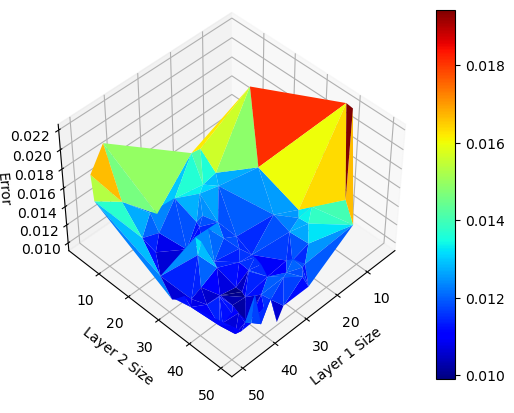

In [10]:
layer_vals = [q['vals'] for q in tpe_trials.miscs]
errs = [q['loss'] if 'loss' in q.keys() else np.NaN for q in tpe_trials.results]
dat = pd.DataFrame(layer_vals)
dat['l1'] = dat['l1'].apply(lambda x : x[0])
dat['l2'] = dat['l2'].apply(lambda x : x[0])
dat['errors'] = errs

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_trisurf(dat['l1'], dat['l2'], dat['errors'], cmap=cm.jet, linewidth=0)
fig.colorbar(surf)

ax.set_xlabel('Layer 1 Size')
ax.set_ylabel('Layer 2 Size')
ax.set_zlabel('Error')
ax.view_init(45, 45)
plt.show()

<h2 id="Makeup_Data">New CNN Class that allows for setting more hyperparameters in the initialization</h2> 

In [11]:
class CNN_batch2(nn.Module):
    
    # Contructor
    def __init__(self, num_convs = 2, layer_sizes = [8,16], kernel_sizes = 5, max_kernel_sizes = 2, number_of_classes=10):
        super(CNN_batch2, self).__init__()
        assert num_convs >= 2 and num_convs <= 3
        assert len(layer_sizes) == num_convs

        layer_sizes = [int(q) for q in layer_sizes]
        kernel_sizes = int(kernel_sizes)
        max_kernel_sizes = int(max_kernel_sizes)
        self.num_layers = int(num_convs)

        layer_sizes = [1] + layer_sizes
        self.conv = []
        for i in range(len(layer_sizes)-1):
            self.conv.append(('Conv' + str(i+1),nn.Conv2d(in_channels=layer_sizes[i], out_channels=layer_sizes[i+1], kernel_size=kernel_sizes, stride=1, \
                                                          padding=int(kernel_sizes/2))))
            self.conv.append(('Batch' + str(i+1),nn.BatchNorm2d(layer_sizes[i+1])))
            self.conv.append(('MaxPool' + str(i+1),nn.MaxPool2d(kernel_size=max_kernel_sizes)))

        self.fc1 = nn.Linear(int(layer_sizes[-1] * (4 ** (4-num_convs))), number_of_classes)
        self.bn_fc1 = nn.BatchNorm1d(10)
    
    # Prediction
    def forward(self, x):
        # input_size = x.shape
        # print(self.num_layers)
        # print('Original' + str(x.shape))
        for i in range(len(self.conv)):
            x = self.conv[i][1](x)
            # print('After conv' + str(x.shape))
            if 'Batch' in self.conv[i][0]:
                x = torch.relu(x)
                # print('After relu' + str(x.shape))
            
        x = x.view(x.size(0), -1)
        # print('After resize' + str(x.shape))
        x = self.fc1(x)
        # print('After FC' + str(x.shape))
        x = self.bn_fc1(x)
        return x

<h2 id="Makeup_Data">Define the Spaces we want to search.  We'll test 2-3 layers of size 3-50 and different kernel sizes and learning rates</h2> 

In [12]:
l1_space = hp.quniform('l1',3,50,1)
l2_space = hp.quniform('l2',3,50,1)
l3_space = hp.quniform('l3',3,50,1)
d_space = hp.quniform('d',2,3,1)
k_sizes = hp.quniform('k',3,7,1)
# Alpha centered at .01 with stdev one a factor of one decimal place 
alpha_space = hp.lognormal('alpha',-4.65,2.32)

space2 = {'l1' : l1_space,\
         'l2' : l2_space,\
        'l3' : l3_space,\
        'd' : d_space,\
        'k' : k_sizes,\
        'alpha' : alpha_space}


tpe_algo2 = tpe.suggest
tpe_trials2 = Trials()

In [13]:
def objective2(params):
    if params['d'] == 2:
        model_batch=CNN_batch2(num_convs=params['d'], layer_sizes=[params['l1'],params['l2']], kernel_sizes=params['k'],\
                            number_of_classes=10)
    else:
        model_batch=CNN_batch2(num_convs=params['d'], layer_sizes=[params['l1'],params['l2'],params['l3']], kernel_sizes=params['k'],\
                            number_of_classes=10)
    optimizer = torch.optim.SGD(model_batch.parameters(), lr = params['alpha'])
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100)
    validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=10000)
    err=train_model_hp(model=model_batch,n_epochs=10,train_loader=train_loader,validation_loader=validation_loader,optimizer=optimizer)
    return err

In [14]:
# model_batch=CNN_batch2(num_convs=3, layer_sizes=[15,15,15], kernel_sizes=4,\
#                            max_kernel_sizes=2, number_of_classes=10)
# summary(model_batch,(1,16,16))

In [15]:
# Run 100 evals with the tpe algorithm
tpe_best = fmin(fn=objective2, space=space2, algo=tpe_algo2, trials=tpe_trials2, 
                max_evals=100, rstate=np.random.default_rng(50))

print(tpe_best)

100%|██████████| 100/100 [5:30:30<00:00, 198.30s/trial, best loss: 0.020100000000000007] 
{'alpha': 0.008335676540356518, 'd': 2.0, 'k': 3.0, 'l1': 50.0, 'l2': 48.0, 'l3': 37.0}


<h2 id="Makeup_Data">Results of the TPE hyperparameter optimization.  Below are some notes on interprestation of results for each of the hyperparameters</h2>

Learning Rate: It appears the learning rate of 0.01 is about right.  I'm going to run this search again with the learning rate set to 0.01 to give the algorithm better opportunity to fully explore the other hyperparameters without the learning rate as a confounding variable.

Depth of Network: It's interesting the optimization seems to prefer a depth of 2 over 3 despite layer depth=3 having a lower mean and median error than layer depth = 2. The underlying algorithm (TPE) doing the hyperparameter search uses a threshold function, essentially preferring those hyperparameters it believes (via expected improvement) will perform better than than the threshold.  As a result, I think the median result is a more apt metric to gain intuition on how it is choosing the next hyperparameter (since how far you are away from the threshold doesn't matter).  Median error for depth 2 vs 3 is nearly identical, which might help explain why the model isn't choosing depth = 3 more often. 

Kernel Size: This doesn't appear to have a large effect on error.  You can see the algorithm exploring different values for this as it goes on.  I'm a bit surprised the extremes (3, 7) of this didn't fair that poorly given I'd expect kernel size that are too small to have difficulty pulling out larger features and large ones possibly causing an informational bottleneck (due to network size reduction since we aren't padding).  I also might expect large kernel sizes to have difficulty identifying small features at the edge of images without padding since the advantage of translational invariance of CNNs is lost in this special case.  It might be interesting to test this hypothesis by translating training data and training with a large kernel.

Layers Sizes: It appears larger layers are better able to learn.  Though, interestingly, it appears more prevalant for deeper rather than shallower layers.  This is consistent with modern CNN archtectures which add more filters as image size is reduced.  I suspect larger quantities of filters at deeper layers help compensate for decreased image/parameter sizes, helping avoid an informational bottleneck.  It also intuitively makes sense.  Earlier layers tend to model simpler shapes (ex. lines, curves, etc), of which there are fewer.  Later layers tend to model more complex shapes (circles, combinations of lines and curves, digits), of which there are fewer.  As a result, you need less filters to represent base shapes at earlier layers and more filters to represent a larger set of combinations of base shapes. 

In [41]:
def plot_hpt(dat, datcols):
    titles = ['Depth of Network', 'Kernel Size', 'Layer 1 Size', 'Layer 2 Size', 'Layer 3 Size']
    for (i,col) in enumerate(datcols):
        if titles[i] in ['Depth of Network', 'Kernel Size']:
            summ_table = pd.DataFrame(data={'Unique Value':dat[col].sort_values().unique()})
            summ_table['N'] = [dat.loc[dat[col] == uval,'errors'].shape[0] for uval in summ_table['Unique Value']]
            summ_table['Median Error'] = [dat.loc[dat[col] == uval,'errors'].median() for uval in summ_table['Unique Value']]
            summ_table['Mean Error'] = [dat.loc[dat[col] == uval,'errors'].mean() for uval in summ_table['Unique Value']]
            summ_table['Min Error'] = [dat.loc[dat[col] == uval,'errors'].min() for uval in summ_table['Unique Value']]
            summ_table['Q1 Error'] = [dat.loc[dat[col] == uval,'errors'].quantile(.25) for uval in summ_table['Unique Value']]
            display(summ_table)
        plt.scatter(dat[col],dat['errors'])
        plt.xlabel(titles[i])
        plt.ylabel('Error')
        plt.title('Performance Relative to ' + titles[i])
        plt.show()

        plt.plot(range(dat.shape[0]),dat[col])
        plt.title('Choice of ' + titles[i])
        plt.xlabel('Iteration')
        plt.ylabel(titles[i])
        plt.show()

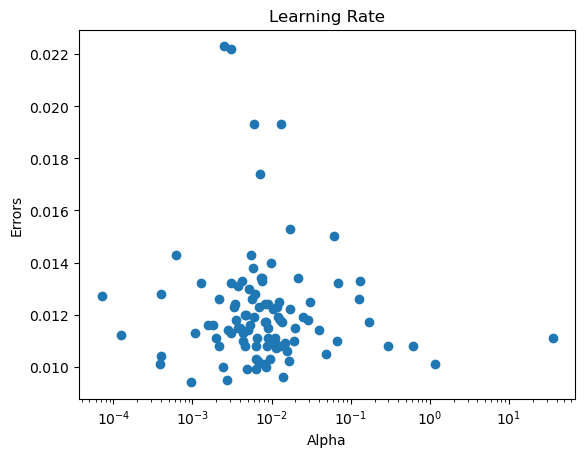

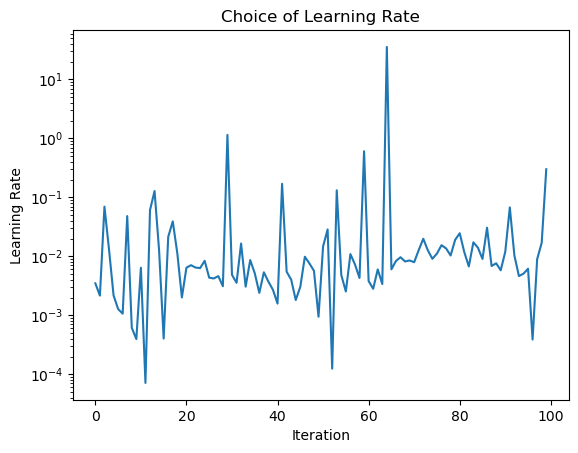

,Unique Value,N,Median Error,Mean Error,Min Error,Q1 Error
0,2.0,78,0.0117,0.012264,0.0099,0.010925
1,3.0,22,0.0114,0.011668,0.0094,0.010800


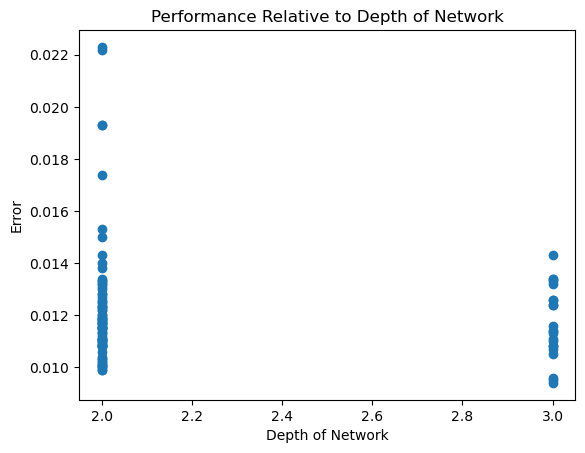

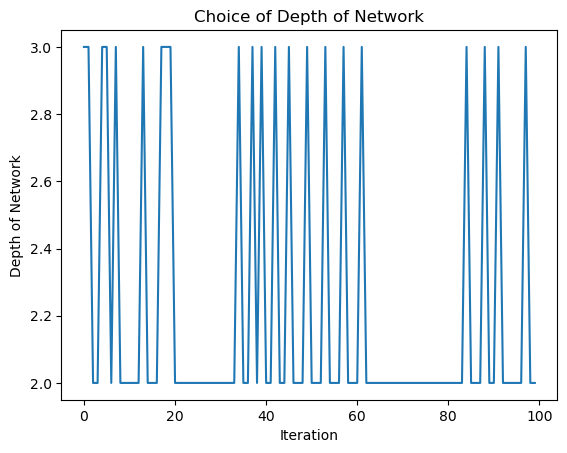

,Unique Value,N,Median Error,Mean Error,Min Error,Q1 Error
0,3.0,29,0.0117,0.011993,0.0096,0.01080
1,4.0,19,0.0115,0.011700,0.0101,0.01105
2,5.0,17,0.0124,0.012776,0.0094,0.01070
3,6.0,21,0.0118,0.012505,0.0099,0.01080
4,7.0,14,0.0115,0.011671,0.0095,0.01110


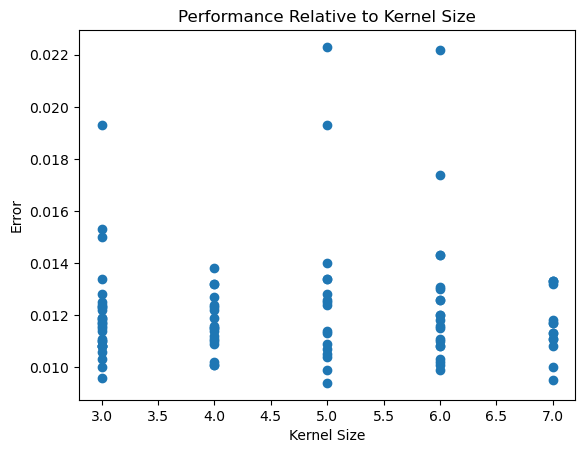

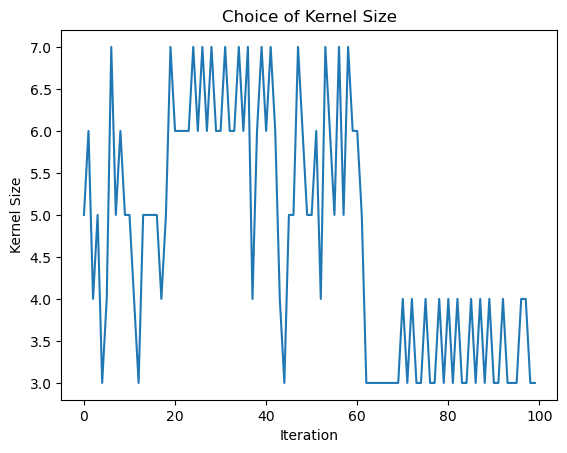

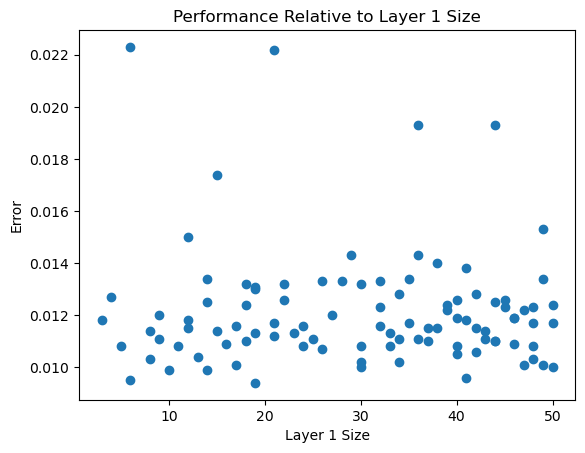

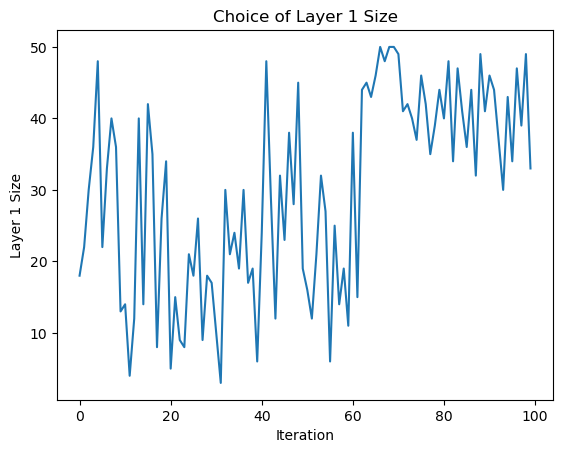

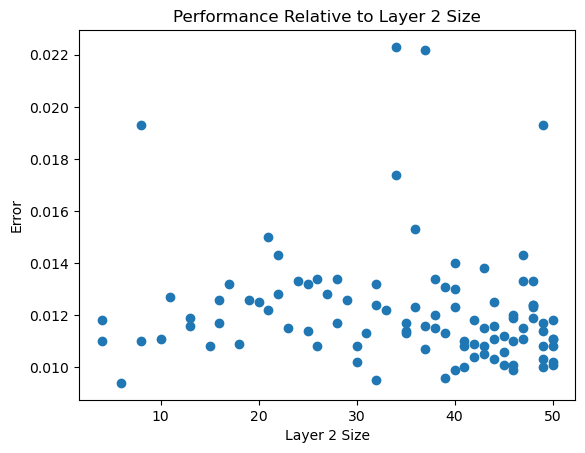

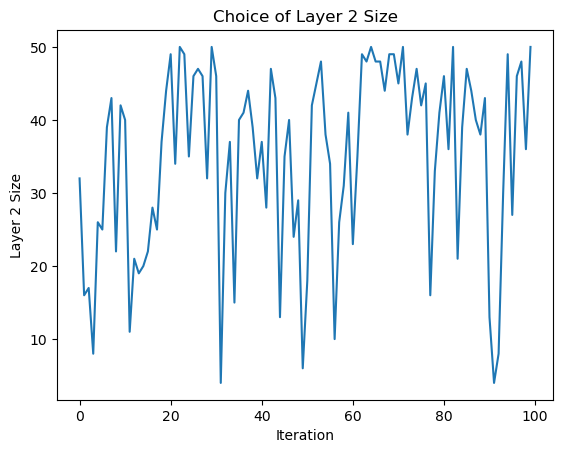

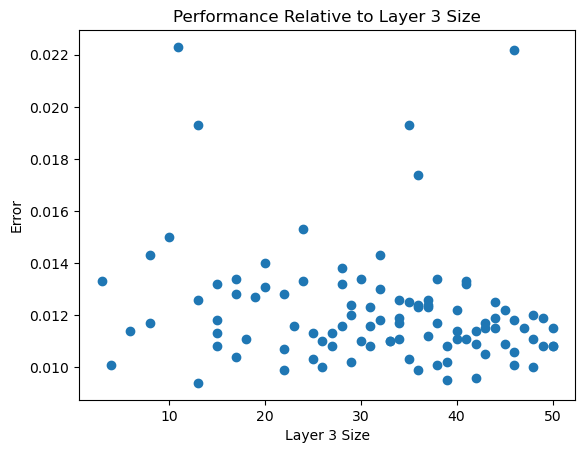

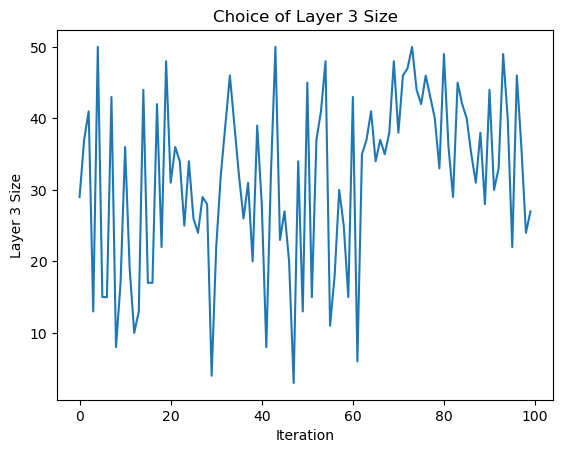

In [42]:
layer_vals2 = [q['vals'] for q in tpe_trials2.miscs]
errs2 = [q['loss'] for q in tpe_trials2.results]
dat2 = pd.DataFrame(layer_vals2)
unlist = lambda x : x[0] if type(x) == list else x
for i in dat2.columns:
    dat2[i] = dat2[i].apply(unlist)
dat2['errors'] = errs

plt.scatter(dat2['alpha'],dat2['errors'])
plt.xlabel('Alpha')
plt.ylabel('Errors')
plt.xscale('log')
plt.title('Learning Rate')
plt.show()

plt.plot(range(dat2.shape[0]),dat2['alpha'])
plt.title('Choice of Learning Rate')
plt.xlabel('Iteration')
plt.ylabel('Learning Rate')
plt.yscale('log')
plt.show()

plot_hpt(dat2,dat2.columns[1:-1])

<h2 id="Makeup_Data">Results of the TPE hyperparameter optimization without alpha.  See notes above for interpretation.  These results were largely similar</h2>



In [17]:
space3 = {'l1' : l1_space,\
         'l2' : l2_space,\
        'l3' : l3_space,\
        'd' : d_space,\
        'k' : k_sizes}


tpe_algo3 = tpe.suggest
tpe_trials3 = Trials()

def objective3(params):
    if params['d'] == 2:
        model_batch=CNN_batch2(num_convs=params['d'], layer_sizes=[params['l1'],params['l2']], kernel_sizes=params['k'],\
                            number_of_classes=10)
    else:
        model_batch=CNN_batch2(num_convs=params['d'], layer_sizes=[params['l1'],params['l2'],params['l3']], kernel_sizes=params['k'],\
                            number_of_classes=10)
    optimizer = torch.optim.SGD(model_batch.parameters(), lr = 0.01)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100)
    validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=10000)
    err=train_model_hp(model=model_batch,n_epochs=10,train_loader=train_loader,validation_loader=validation_loader,optimizer=optimizer)
    return err

# Run 100 evals with the tpe algorithm
tpe_best = fmin(fn=objective3, space=space3, algo=tpe_algo3, trials=tpe_trials3, 
                max_evals=100, rstate=np.random.default_rng(50))

print(tpe_best)

100%|██████████| 100/100 [5:05:34<00:00, 183.35s/trial, best loss: 0.021599999999999953] 
{'d': 2.0, 'k': 3.0, 'l1': 6.0, 'l2': 48.0, 'l3': 24.0}


,Unique Value,N,Median Error,Mean Error,Min Error,Q1 Error
0,2.0,78,0.01170,0.012287,0.0096,0.010925
1,3.0,22,0.01135,0.011586,0.0094,0.010800


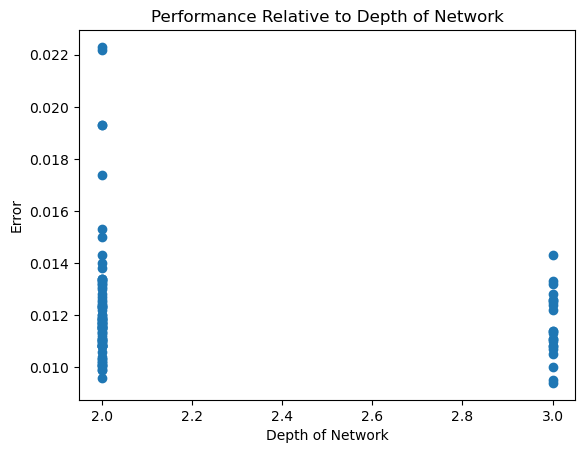

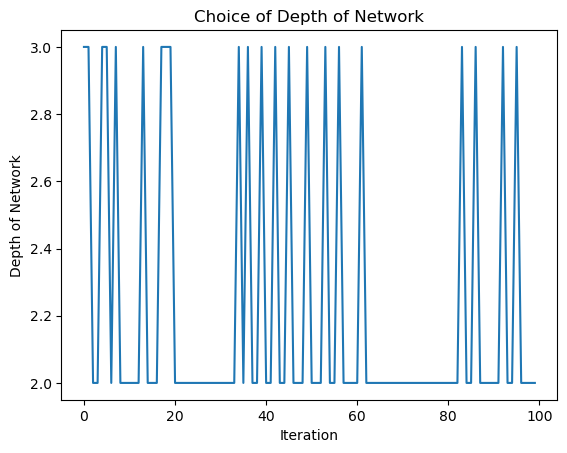

,Unique Value,N,Median Error,Mean Error,Min Error,Q1 Error
0,3.0,33,0.01190,0.012055,0.0095,0.011300
1,4.0,28,0.01150,0.012143,0.0094,0.010875
2,5.0,18,0.01210,0.012078,0.0099,0.010825
3,6.0,13,0.01260,0.013154,0.0099,0.011000
4,7.0,8,0.01095,0.010888,0.0100,0.010675


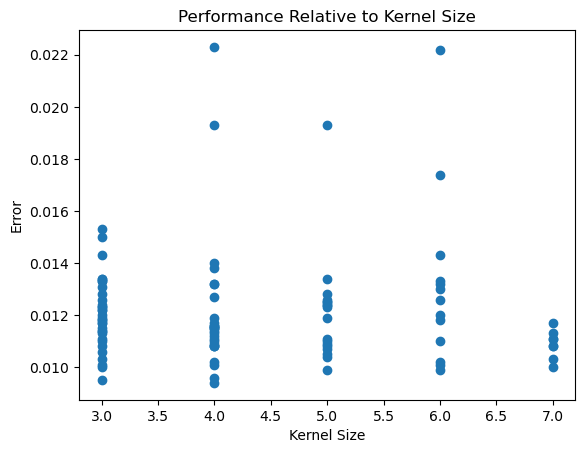

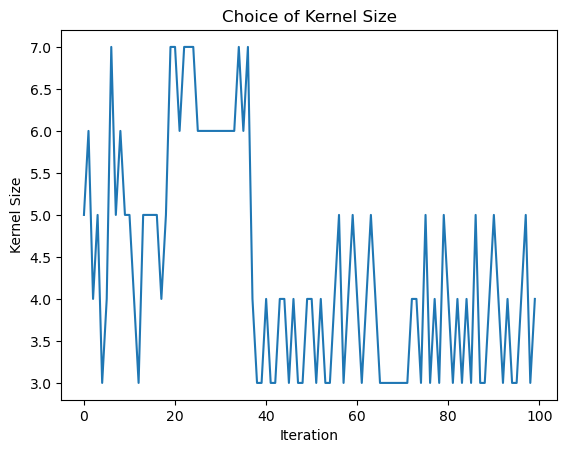

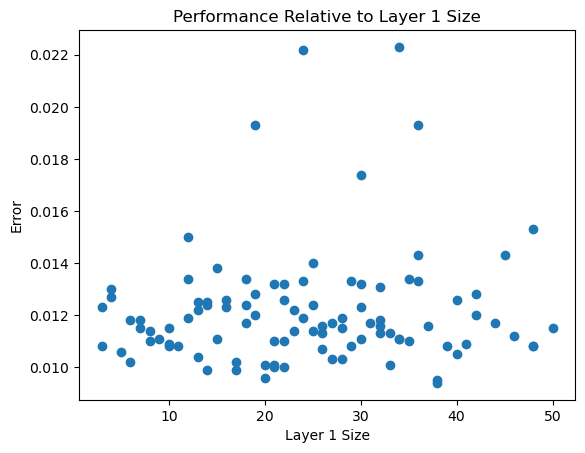

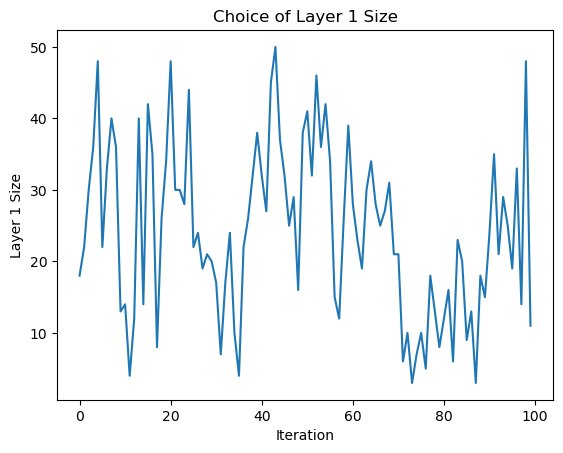

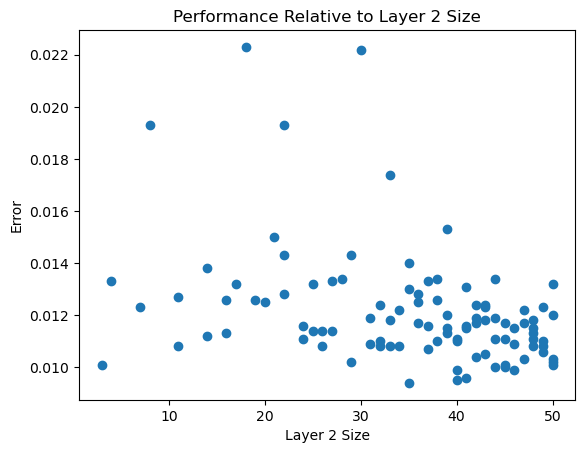

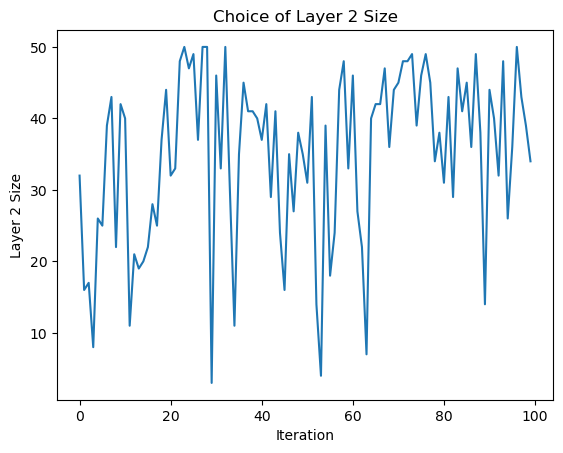

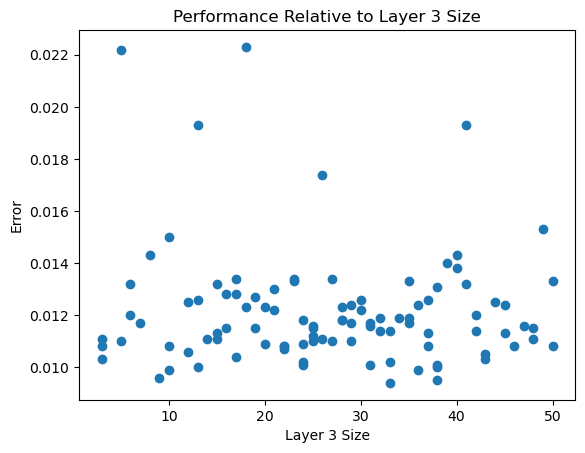

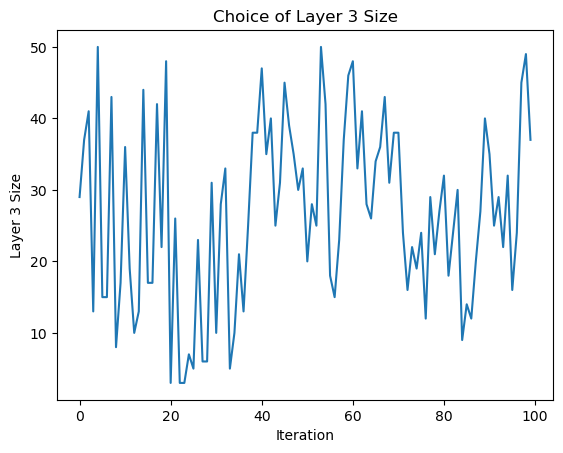

In [45]:
layer_vals3 = [q['vals'] for q in tpe_trials3.miscs]
errs3 = [q['loss'] for q in tpe_trials3.results]
dat3 = pd.DataFrame(layer_vals3)
unlist = lambda x : x[0] if type(x) == list else x
for i in dat3.columns:
    dat3[i] = dat3[i].apply(unlist)
dat3['errors'] = errs

plot_hpt(dat3,dat3.columns[:-1])

<!--Empty Space for separating topics-->
